In [1]:
from alabi.cache_utils import load_model_cache
import os
import sys
sys.path.append(os.path.realpath("../src"))
import tidal
import warnings
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
font = {'family' : 'normal',
        'weight' : 'light'}
rc('font', **font)

import astropy.constants as c
import astropy.units as u

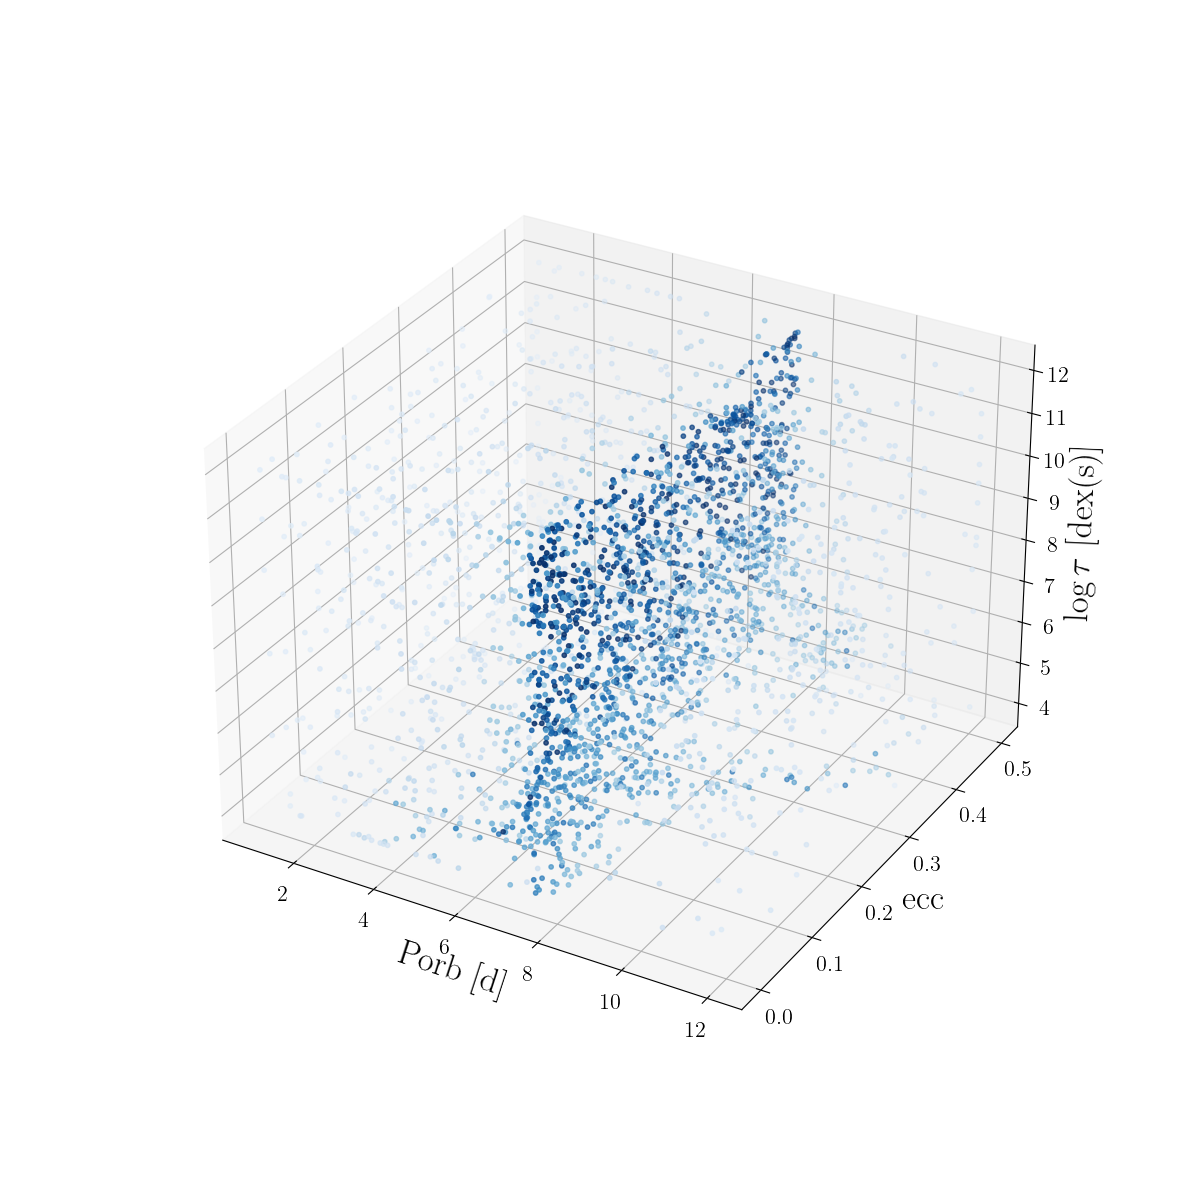

In [2]:
%matplotlib widget

config_id = 110
sm = load_model_cache(f"../analysis/results_alabi/config_{config_id}/")

tt = sm.theta.T
cb_rng = [6,12]

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(projection='3d')

ax.scatter(tt[3], tt[2], tt[4], c=-sm.y, s=10, cmap="Blues_r", norm=colors.LogNorm(vmin=10**min(cb_rng), vmax=10**max(cb_rng)))
ax.set_xlabel("Porb [d]", fontsize=25)
ax.set_ylabel("ecc", fontsize=25)
ax.set_zlabel(r"$\log\tau$ [dex(s)]", fontsize=25)
plt.show()

In [20]:
def Jorb(m1, m2, porb, e):
    jsq = c.G * m1**2 * m2**2 / (m1 + m2) * (1 - e**2) 
    jsq *= (c.G * (m1 + m2) / (4*np.pi**2) * porb**2)**(1/3)
    return np.sqrt(jsq.si)

def Torb(m1, m2, jorb, ecc):
    torb = []
    for e in ecc:
        # period = 2*np.pi * (jorb / (c.G * (m1 + m2) * m1 * m2 * np.sqrt(1 - e**2)))**3
        term = c.G * m1**2 * m2**2 / (m1 + m2) * (1 - e**2) / jorb**2
        term *= (c.G * (m1 + m2) / (4*np.pi**2))**(1/3)
        period = term**(-3/2)
        torb.append(period.to(u.d).value)
    return torb

def semi_major_axis(m1, m2, porb):
    a = (c.G * (m1 + m2) / (4*np.pi**2) * porb**2)**(1/3)
    return a.si.value

def roche_lobe_radius(q):
    rl = 0.49 * q**(2/3) / (0.6*q**(2/3) + np.log(1 + q**(1/3)))
    return rl.value

In [13]:
config_id = 111
file = f"../analysis/config/config_{config_id}.yaml"
synth = tidal.SyntheticModel(file, verbose=False, compute_true=True)
sm = load_model_cache(f"../analysis/results_alabi/config_{config_id}/")

In [14]:
age, q2, psi1, psi2, m1, m2 = np.array(synth.inparams_fix.true) * np.array(synth.inparams_fix.units)
prot1_i, prot2_i, e_i, porb_i, q = np.array(synth.inparams_var.true) * np.array(synth.inparams_var.units) 
porb_f, e_f, prot1_f, prot2_f = np.array(synth.outparams.true) * np.array([u.d, u.dimensionless_unscaled, u.d, u.d])

jorb_i = Jorb(m1, m2, porb_i, e_i)
jorb_f = Jorb(m1, m2, porb_f, e_f)

e_arr = np.arange(0,0.6,0.01) 
pf_i = Torb(m1, m2, jorb_i, e_arr)
pf_f = Torb(m1, m2, jorb_f, e_arr)

In [23]:
print(synth.outparams)

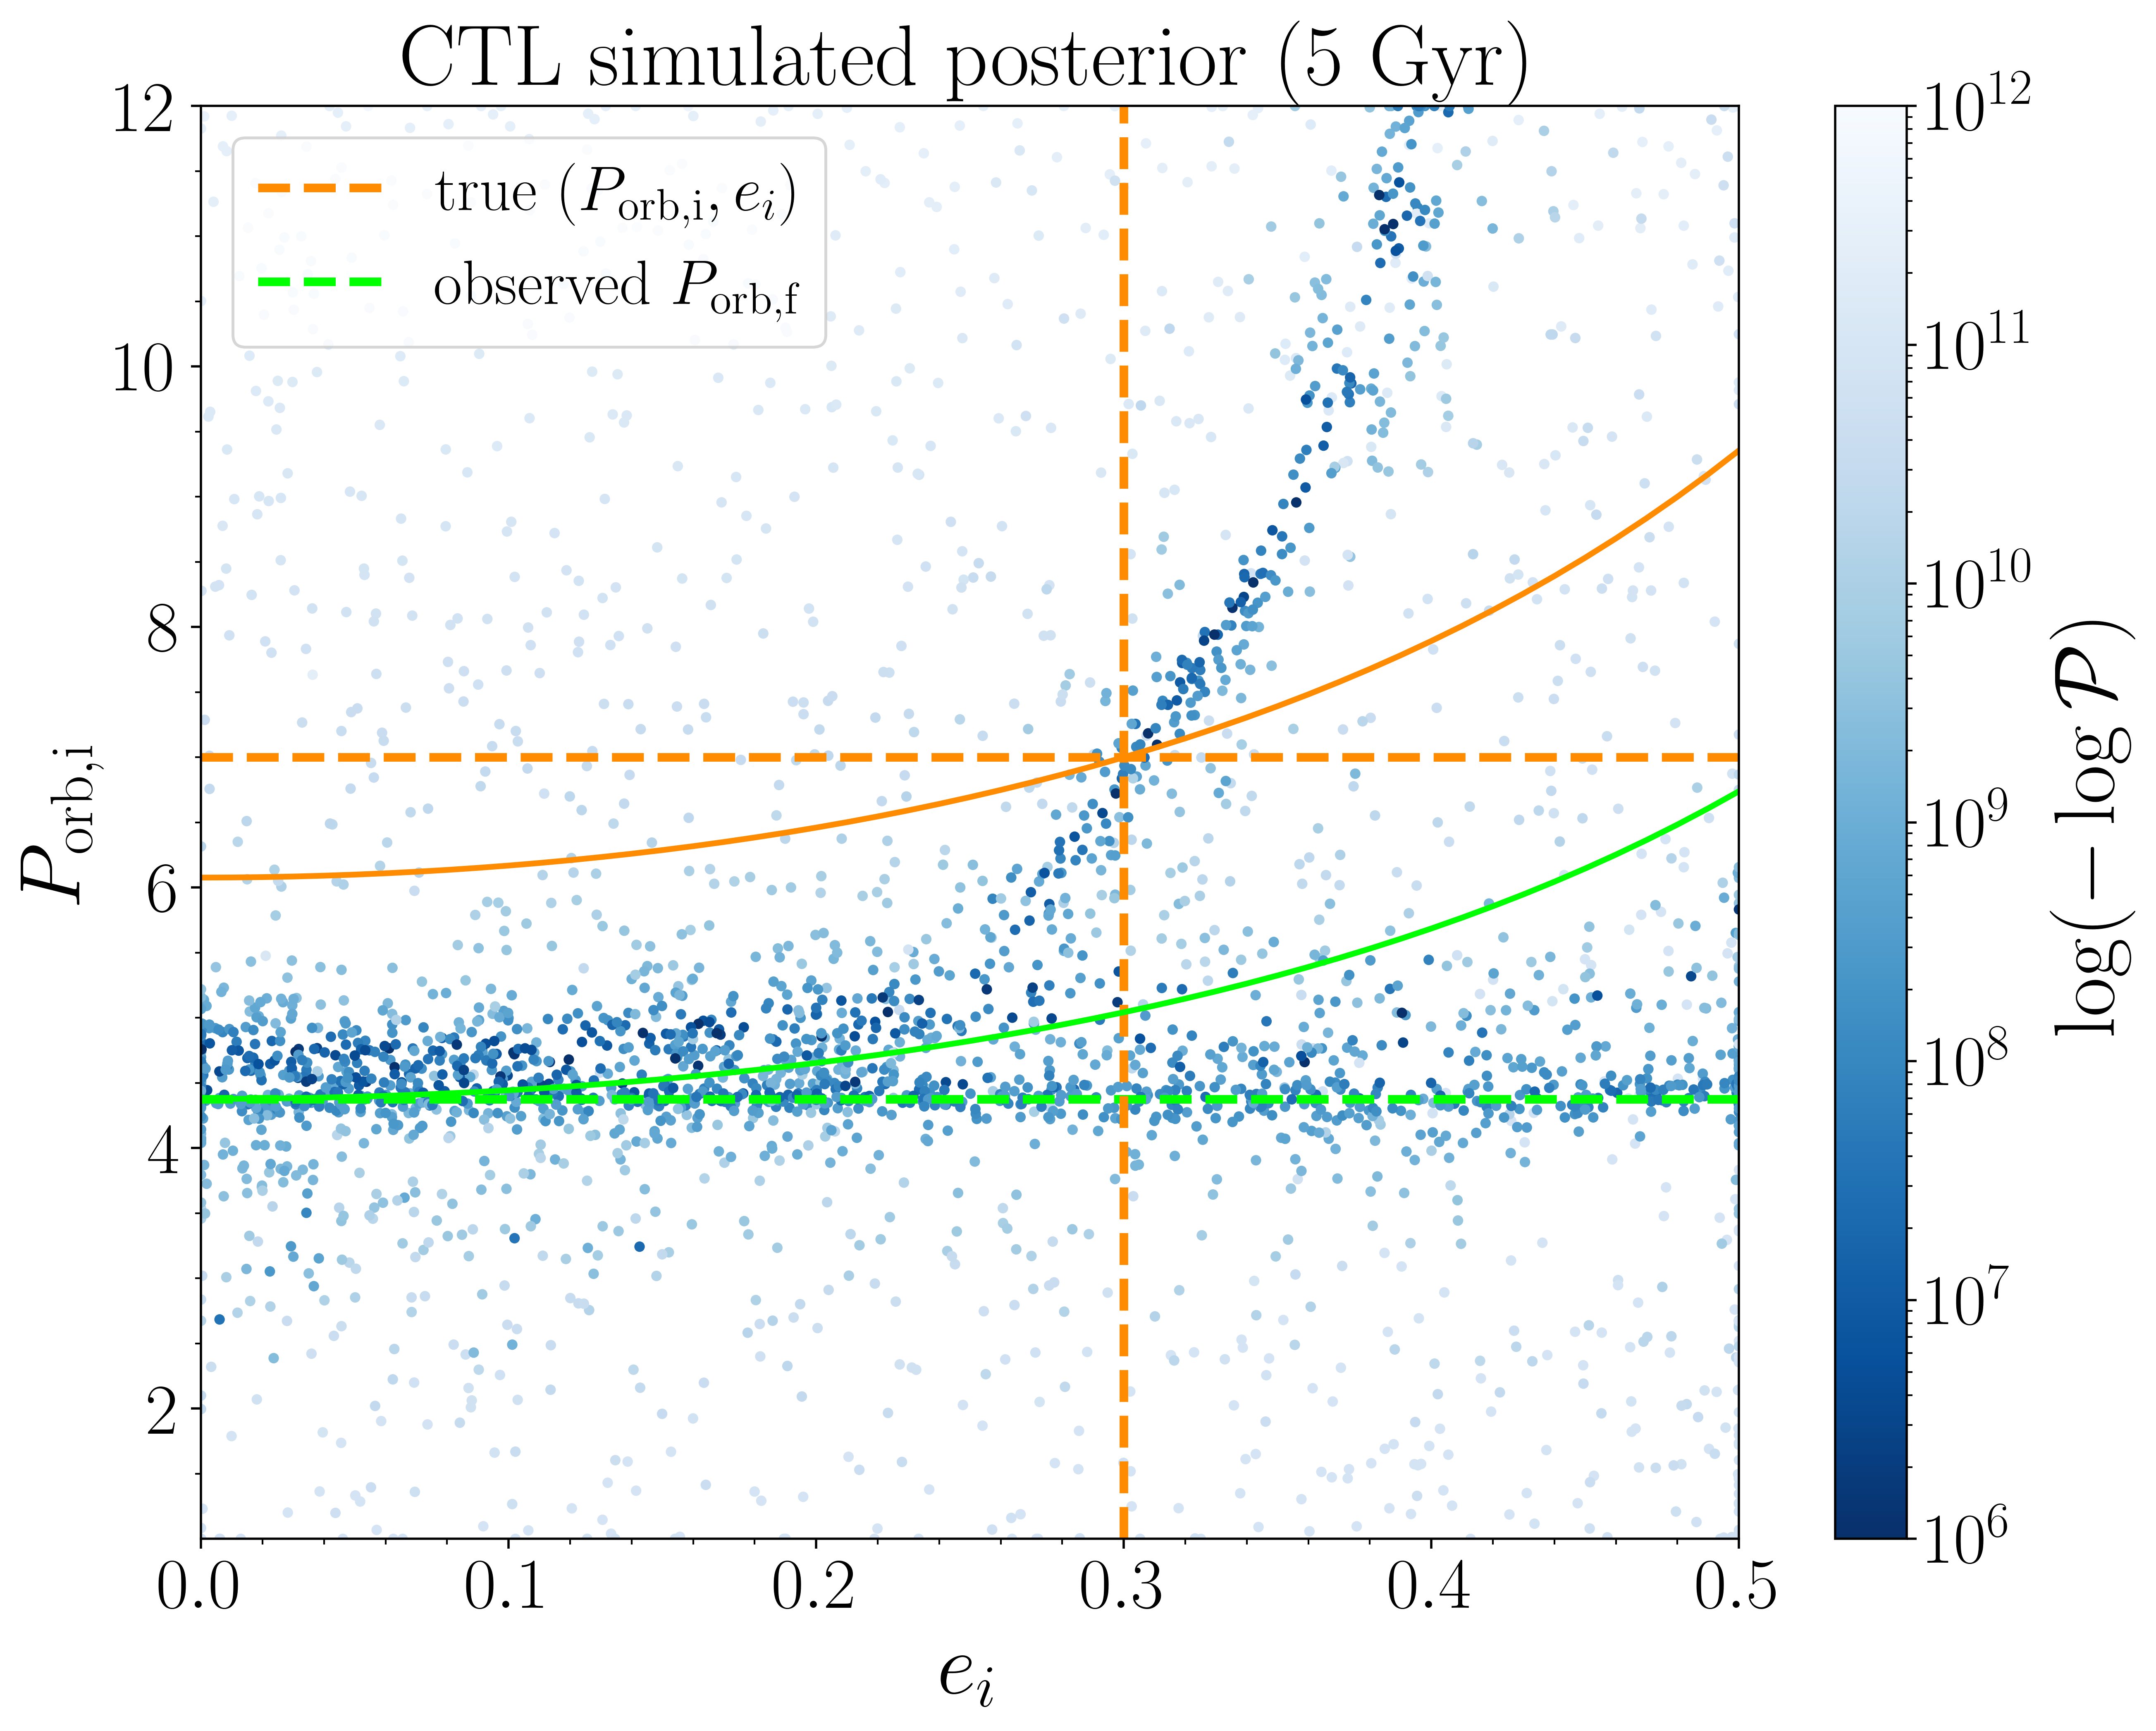

In [15]:
%matplotlib inline

prot1, prot2, ecc, porb, q = sm.theta.T

fig = plt.figure(figsize=[12,9], dpi=500)
cb_rng = [6,12]

im = plt.scatter(ecc, porb, c=-sm.y, s=7, cmap="Blues_r", norm=colors.LogNorm(vmin=10**min(cb_rng), vmax=10**max(cb_rng)), alpha=1)
plt.axhline(synth.inparams_var.true[3], color='darkorange', linewidth=3, linestyle='--', label=r"true $(P_{\rm orb,i}, e_i)$")
plt.axhline(synth.outparams.true[3], color='lime', linewidth=3, linestyle='--', label=r"observed $P_{\rm orb,f}$")
plt.axvline(synth.inparams_var.true[2], color='darkorange', linewidth=3, linestyle='--')
plt.plot(e_arr, pf_i, color="darkorange", linewidth=2)
plt.plot(e_arr, pf_f, color="lime", linewidth=2)

cb = fig.colorbar(im)
cb.set_label(r'$\log(-\log\mathcal{P})$', fontsize=30)
cb.ax.tick_params(labelsize=25)

plt.xlabel(r"$e_i$", fontsize=30)
plt.ylabel(r"$P_{\rm orb,i}$", fontsize=30)
plt.title("CTL simulated posterior (5 Gyr)", fontsize=30)
plt.legend(loc="upper left", fontsize=22)
    
plt.xlim(min(ecc), max(ecc))
plt.ylim(min(porb), max(porb))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.minorticks_on()
# fig.savefig(f"/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/simulated_posterior_cpl_5gyr_zoom.png")
# fig.savefig(f"/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/simulated_posterior_ctl_5gyr_zoom.png")
plt.show()

In [22]:
roche_lobe_radius(m2/m1)

0.3789205183804563

In [21]:
roche_lobe_radius(m2/m1) * semi_major_axis(m1, m2, porb)

array([2692524.1478723 , 1143016.48808036,  971613.69493414, ...,
       2060521.15967343, 2083764.59865984, 3276379.66537259])